In [2]:
# import library
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pysal as ps
import geopandas as gpd

%matplotlib notebook

/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Load the regression dataset

In [3]:
# load the data set 
data = pd.read_stata('/Volumes/Transcend/Liu_Final Project_The geography of cultural entrepreneurship /metro_micro_var_2019_Nov.dta')
pd.set_option('display.max_columns', 100)

In [4]:
data['msacode'] = data['msacode'].astype(int)
data = data.set_index('msacode')

In [5]:
data.shape

(909, 249)

# Spatial model and Moran's I

In [6]:
#merge with county shapfile
cbsa = gpd.GeoDataFrame.from_file('data/tl_2013_us_cbsa/tl_2013_us_cbsa.shp')

In [7]:
cbsa['GEOID'] = cbsa['GEOID'].astype(int)
cbsa = cbsa.set_index('GEOID').sort_values(by='GEOID')

# join to the cbsa shapfiles
cbsa_data = pd.merge(left=cbsa, right=data, how='right', left_index=True, right_index=True)

In [8]:
#drop missing values
cbsa_data = cbsa_data.dropna(subset=['msatitle'])
cbsa_data.shape

(909, 261)

## Specify micropolitan and metropolitan area model

In [9]:
micro_cbsa_data = cbsa_data[cbsa_data['microarea'] == 1]
micro_cbsa_data.shape

(532, 261)

In [10]:
micropolitan_geo = gpd.GeoDataFrame(micro_cbsa_data)

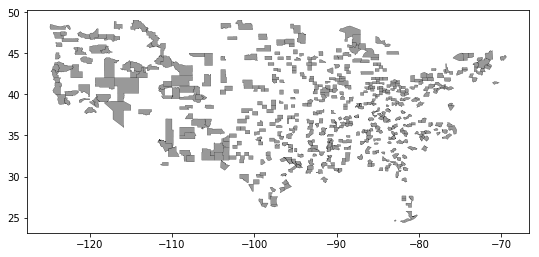

In [11]:
fig, ax = plt.subplots(figsize=(9, 9))
micropolitan_geo.plot(ax=ax, facecolor='#999999', edgecolor='k', linewidth=0.2)

In [12]:
metro_cbsa_data = cbsa_data[cbsa_data['metroarea'] == 1]
metropolitan_geo = gpd.GeoDataFrame(metro_cbsa_data)
metro_cbsa_data.shape

(377, 261)

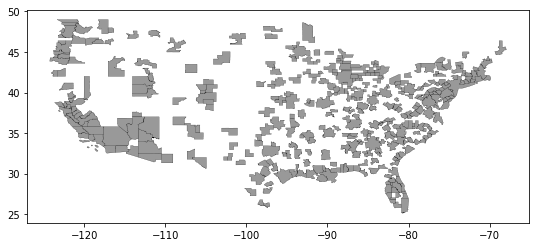

In [13]:
fig, ax = plt.subplots(figsize=(9, 9))
metropolitan_geo.plot(ax=ax, facecolor='#999999', edgecolor='k', linewidth=0.2)

## Spatial diagnostics - micropolitan area

Explore spatial dependence, starting by using spatial distance weights to model spatial relationships between observations and OLS to check diagnostics.

In [14]:
def run_ols_diagnostics(spatial_dataset, response, predictors, model_name):
    #1.specify X and Y variables
    X = spatial_dataset[predictors].dropna()
    Y = spatial_dataset.loc[X.index][[response]]
    
    #2.calculate distance weight
    x1 = spatial_dataset.centroid.x
    y1 = spatial_dataset.centroid.y
    coords = np.array([x1, y1]).T
    
        #minimum nearest neighbor distance should be determined so that each unit is assured of at least one neighbor
    threshold = ps.lib.weights.min_threshold_distance(coords)
    not_null = spatial_dataset[[response, 'geometry']].dropna() 
    y = not_null[response]
    W = ps.lib.weights.distance.DistanceBand.from_dataframe(not_null, threshold=threshold, binary=False, alpha=-2)
    W.set_transform('R')
    
    #3.compute OLS spatial diagnostics to check the nature of spatial dependence
    ols = ps.model.spreg.OLS(y=Y.values, x=X.values, w=W, robust='white', spat_diag=True, moran=True, name_w='distance',
                            name_x=X.columns.tolist(), name_y=response, name_ds=model_name)
    # moran's I (for the residuals): moran's i, standardized i, p-value
    print("Moran's I, standardized I, p-value:" , ols.moran_res)  
    print(ols.summary)
    return ols.summary


In [15]:
predictors = ['popchange00_10', 'lnpop_den', 'percent_foreignborn', 'femaleemp', 'age25_44rate', 
              'age45_64rate', 'estsize', 'belowpovrate', 'Unemtrate', 'per_Upatent10', 'per_Dpatent10', 
              'bachelorhigher', 'Scale', 'socialcapital', 'adjacentto1mmetro', 'const_LQ', 'manu_LQ', 
              'wholesale_LQ', 'retail_LQ', 'trans_LQ', 'info_LQ', 'fin_LQ', 'realty_LQ', 'profScie_LQ', 
              'manage_LQ', 'admin_LQ', 'edu_LQ', 'health_LQ', 'art_LQ', 'food_LQ', 'SBIR_compcount', 'Region1', 'Region3', 'Region4']

predictors1 = ['popchange00_10', 'lnpop_den', 'percent_foreignborn', 'femaleemp', 'age25_44rate', 
              'age45_64rate', 'estsize', 'belowpovrate', 'Unemtrate', 'per_Upatent10', 'per_Dpatent10', 
              'bachelorhigher', 'Scale', 'socialcapital', 'adjacentto1mmetro', 'SBIR_compcount', 'Region1', 'Region3', 'Region4']


response = 'birthrate10_15_emp'
response1 = 'hightechbirthrate10_15_emp'

In [16]:
model_name = 'Micropolitan_areas'
run_ols_diagnostics(micro_cbsa_data, response, predictors1, model_name)

Moran's I, standardized I, p-value: (0.12405793713824802, 6.04028680786745, 1.53840526776664e-09)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Micropolitan_areas
Weights matrix      :    distance
Dependent Variable  :birthrate10_15_emp                Number of Observations:         532
Mean dependent var  :     49.6733                Number of Variables   :          20
S.D. dependent var  :     22.1254                Degrees of Freedom    :         512
R-squared           :      0.7557
Adjusted R-squared  :      0.7466
Sum squared residual:   63508.700                F-statistic           :     83.3484
Sigma-square        :     124.040                Prob(F-statistic)     :  5.607e-143
S.E. of regression  :      11.137                Log likelihood        :   -2026.964
Sigma-square ML     :     119.377                Akaike info criterion :    4093.928
S.E of regression ML:     10.9260                Schw

In [31]:
model_name = 'Micropolitan_areas'
run_ols_diagnostics(micro_cbsa_data, response1, predictors1, model_name)

Moran's I, standardized I, p-value: (0.1401935875251527, 6.746834259915999, 1.5110571294875306e-11)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Micropolitan_areas
Weights matrix      :    distance
Dependent Variable  :hightechbirthrate10_15_emp                Number of Observations:         532
Mean dependent var  :      2.5636                Number of Variables   :          20
S.D. dependent var  :      2.4381                Degrees of Freedom    :         512
R-squared           :      0.5510
Adjusted R-squared  :      0.5343
Sum squared residual:    1417.387                F-statistic           :     33.0626
Sigma-square        :       2.768                Prob(F-statistic)     :   1.817e-76
S.E. of regression  :       1.664                Log likelihood        :   -1015.536
Sigma-square ML     :       2.664                Akaike info criterion :    2071.072
S.E of regression ML:      1.6323          

###  Moran's I

In [ ]:
# calculate moran's I (for the response) and its significance
mi = ps.explore.esda.Moran(y=Y, w=W, two_tailed=True)
print(mi.I)
print(mi.p_sim)

In [ ]:
# moran's I (for the residuals): moran's i, standardized i, p-value
ols.moran_res

In [ ]:
y_lag = ps.lib.weights.lag_spatial(W, y)

firm_birth_lag = '{}_lag'.format(firm_birth)
data_lag = pd.DataFrame(data={firm_birth:y, firm_birth_lag:y_lag}).astype(float)

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=firm_birth, y=firm_birth_lag, data=data_lag, scatter_kws={'s':1})
plt.show()

# Spatial diagnostics - metropolitan area

In [19]:
predictors = ['popchange00_10', 'lnpop_den', 'percent_foreignborn', 'femaleemp', 'age25_44rate', 
              'age45_64rate', 'estsize', 'belowpovrate', 'Unemtrate', 'per_Upatent10', 'per_Dpatent10', 
              'bachelorhigher', 'Scale', 'socialcapital', 'const_LQ', 'manu_LQ', 
              'wholesale_LQ', 'retail_LQ', 'trans_LQ', 'info_LQ', 'fin_LQ', 'realty_LQ', 'profScie_LQ', 
              'manage_LQ', 'admin_LQ', 'edu_LQ', 'health_LQ', 'art_LQ', 'food_LQ', 'SBIR_compcount', 'Region1', 'Region3', 'Region4']

predictors1 = ['popchange00_10', 'lnpop_den', 'percent_foreignborn', 'femaleemp', 'age25_44rate', 
              'age45_64rate', 'estsize', 'belowpovrate', 'Unemtrate', 'per_Upatent10', 'per_Dpatent10', 
              'bachelorhigher', 'Scale', 'socialcapital', 'SBIR_compcount', 'Region1', 'Region3', 'Region4']


response = 'birthrate10_15_emp'
response1 = 'hightechbirthrate10_15_emp'

In [22]:
model_name = 'Metropolitan_areas'
run_ols_diagnostics(metro_cbsa_data, response, predictors1, model_name)

Moran's I, standardized I, p-value: (0.19899036859898822, 7.522072112693523, 5.3914830968368604e-14)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Metropolitan_areas
Weights matrix      :    distance
Dependent Variable  :birthrate10_15_emp                Number of Observations:         377
Mean dependent var  :     46.9549                Number of Variables   :          19
S.D. dependent var  :     17.5140                Degrees of Freedom    :         358
R-squared           :      0.8786
Adjusted R-squared  :      0.8724
Sum squared residual:   14007.331                F-statistic           :    143.8733
Sigma-square        :      39.127                Prob(F-statistic)     :  1.456e-151
S.E. of regression  :       6.255                Log likelihood        :   -1216.384
Sigma-square ML     :      37.155                Akaike info criterion :    2470.769
S.E of regression ML:      6.0955                S

/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [23]:
model_name = 'Metropolitan_areas'
run_ols_diagnostics(metro_cbsa_data, response1, predictors1, model_name)

Moran's I, standardized I, p-value: (0.3121913172991233, 11.414298008231214, 3.547565967055502e-30)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Metropolitan_areas
Weights matrix      :    distance
Dependent Variable  :hightechbirthrate10_15_emp                Number of Observations:         377
Mean dependent var  :      3.7446                Number of Variables   :          19
S.D. dependent var  :      2.6133                Degrees of Freedom    :         358
R-squared           :      0.7411
Adjusted R-squared  :      0.7281
Sum squared residual:     664.751                F-statistic           :     56.9384
Sigma-square        :       1.857                Prob(F-statistic)     :   2.589e-93
S.E. of regression  :       1.363                Log likelihood        :    -641.851
Sigma-square ML     :       1.763                Akaike info criterion :    1321.701
S.E of regression ML:      1.3279          

/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
